In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx
import frame as frame
from numba import jit, njit, prange
import scipy.linalg as la


mpl.rcParams.update({'font.size': 25})

In [2]:
# size of network
N = 6

# adjacency matrix
A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])
frame.printMatrix(A)

0.00   1.00   0.00   1.00   1.00   0.00   

1.00   0.00   1.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   1.00   0.00   



In [3]:
# master operator, values from Rick in SuppMat
L = np.zeros((N, N))
# fill with values
L[0, 1] = 5.997
L[1, 0] = 0.774

L[0, 3] = 13.439
L[3, 0] = 127.968

L[0, 4] = 15.330
L[4, 0] = 0.121

L[4, 5] = 3.749
L[5, 4] = 13.326

L[1, 2] = 1514.820
L[2, 1] = 53.0661

L[1, 5] = 13.441
L[5, 1] = 2.922

L = L.T

#diagonal elements
for i in range(N):
    L[i,i] = -np.sum(L[:, i])


frame.printMatrix(L)

-34.77   0.77   0.00   127.97   0.12   0.00   

6.00   -1529.03   53.07   0.00   0.00   2.92   

0.00   1514.82   -53.07   0.00   0.00   0.00   

13.44   0.00   0.00   -127.97   0.00   0.00   

15.33   0.00   0.00   0.00   -3.87   13.33   

0.00   13.44   0.00   0.00   3.75   -16.25   



In [4]:
# find eigenvalues and eigenvectors
ew, ev = sc.linalg.eig(L)
print(ew)
# frame.printMatrix(ev)

# relevant eigenvector has eigenvalue 0
peq = ev[:, 4]
# print(peq)

# need to "normalise" it such that sum of entries is 1

Z = np.sum(peq)
# print(Z)
peq = peq / Z

print(np.sum(peq))

print(peq)

print(np.sort(np.abs(ew)))

[-1.58165132e+03+0.j -1.43749631e+02+0.j -1.98531625e+01+0.j
 -1.86991129e+01+0.j  1.53222889e-13+0.j -9.99871767e-01+0.j]
1.0
[2.54859615e-03 1.97475509e-02 5.63711767e-01 2.67649597e-04
 3.22886823e-01 9.08376128e-02]
[1.53222889e-13 9.99871767e-01 1.86991129e+01 1.98531625e+01
 1.43749631e+02 1.58165132e+03]


In [5]:
# check for DB
for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            print("%.5f \t %.5f \t %.5f" % (L[i, j]*peq[j], L[j, i]*peq[i], L[j, i]*peq[i] / (L[i, j]*peq[j])))

0.01528 	 0.01528 	 0.99996
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 1.00002
0.01528 	 0.01528 	 1.00004
29.91399 	 29.91399 	 1.00000
0.26543 	 0.26543 	 1.00000
29.91399 	 29.91399 	 1.00000
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 0.99998
1.21050 	 1.21050 	 1.00000
0.26543 	 0.26543 	 1.00000
1.21050 	 1.21050 	 1.00000


In [6]:
# initial distribution
initial_p = np.array([0, 0, 0, 0, 0, 1])

# # initialise class
# system = frame.JumpProcessMasterEquation(N, initial_p, L, 100)

In [7]:
@jit
def master_eq_evolution(t:float, L: np.ndarray, initial_dist):
        
        propagator = la.expm(L * t)

        return np.matmul(propagator, initial_dist)

def initial_state(initial_p, states):
    """Function to randomly determine initial condition given a initial distribution

    Returns:
        int: (random) initial state
    """
    n_0 = rn.choice(states, 1, p=initial_p)

    return n_0[0]

@njit
def Trajectory_sample(init_state: int, final_time: float, L: np.ndarray):
    
    # list with states in it
    trajectory = [init_state]
    I = init_state
    # list of transition times to the next respective states
    state_time = []

    Gamma = -np.diag(L)

    N = len(L)
    # print(transition_matrix[trajectory[-1]-1, trajectory[-1]-1])
    # start at time 0
    tau = 0
    while tau <= final_time:
        # draw the escape time according to an exponential distribution
        # note that the index for states starts at 1, hence we have to subtract to get the appropriate index
        r1, r2 = np.random.uniform(0,1, 2)

        temp = 0

        for J in range(N):
            if J == I:
                p_ij = 0
            else:
                p_ij = L[J][I] / (-L[I][I])
            
            temp += p_ij

            if temp >= r2:
                tau += -np.log(r1) / Gamma[I]
                I = J
                trajectory.append(I)
                state_time.append(tau)
                break
            else:
                continue

    return np.asarray(trajectory), np.asarray(state_time)


@njit(parallel=True)
def current_sample(n_sample:int, time: np.ndarray, init_state:int, L:np.ndarray, d: np.ndarray):
    tmax = time[-1]
    dt = time[1] - time[0] # assume all dt are the same
    nt = len(time)

    J = np.zeros((n_sample, nt-1))

    # n_sample amout of samples
    for i in prange(n_sample):
        traj, t_time = Trajectory_sample(init_state, tmax, L)
        for t in prange(1, nt):
            index = np.where(t_time <= time[t])[0]
            for j in index:
                J[i, t-1] += d[traj[j], traj[j+1]]

    J_mean = np.zeros(nt-1)
    J_var = np.zeros(nt-1)

    # calculate mean and variance
    for t in prange(1, nt):
        J_mean[t-1] = np.mean(J[:, t-1])
        J_var[t-1] = np.var(J[:, t-1])
    print("############# SAMPLE DONE ################")

            
    return J_mean, J_var

# TODO check if matches theory
@njit(parallel=True)
def current_covariance_sample(n_sample:int, time: np.ndarray, init_state:np.ndarray, L:np.ndarray, d1: np.ndarray, d2: np.ndarray):
    tmax = time[-1]
    nt = len(time)

    J1 = np.zeros((n_sample, nt-1))
    J2 = np.zeros((n_sample, nt-1))

    # n_sample amout of samples
    for i in prange(n_sample):
        traj, t_time = Trajectory_sample(init_state[i], tmax, L)
        for t in prange(1, nt):
            index = np.where(t_time <= time[t])[0]
            for j in index:
                J1[i, t-1] += d1[traj[j], traj[j+1]]
                J2[i, t-1] += d2[traj[j], traj[j+1]]

    J1_mean = np.zeros(nt-1)
    J2_mean = np.zeros(nt-1)
    J_cov = np.zeros(nt-1)

    # calculate mean and variance
    for t in prange(1, nt):
        J1_mean[t-1] = np.mean(J1[:, t-1])
        J2_mean[t-1] = np.mean(J2[:, t-1])
        J_cov[t-1] = np.cov(J1[:, t-1], J2[:, t-1])[0, -1]
    print("############# SAMPLE DONE ################")

            
    return J1_mean, J2_mean, J_cov

# TODO check if it matches theory, also for mean and variance of density, but especially for covariance
@njit(parallel=True)
def current_density_sample(n_sample:int, time: np.ndarray, init_state:int, L:np.ndarray, d: np.ndarray, V: np.ndarray):
    tmax = time[-1]
    dt = time[1] - time[0] # assume all dt are the same
    nt = len(time)

    J = np.zeros((n_sample, nt-1))
    rho = np.zeros((n_sample, nt - 1))

    # n_sample amout of samples
    for i in prange(n_sample):
        traj, t_time = Trajectory_sample(init_state[i], tmax, L)
        for t in prange(1, nt):
            index = np.where(t_time <= time[t])[0]
            for j in index:
                J[i, t-1] += d[traj[j], traj[j+1]]
                if j == 0:
                    rho[i, t-1] += V[traj[j]] * t_time[j]
                else: 
                    rho[i, t-1] += V[traj[j]] * (t_time[j] - t_time[j-1])
            
            if len(index) == 0:
                rho[i, t-1] += traj[0] * time[t]
            else:
                rho[i, t-1] += V[traj[index[-1]+1]] * (time[t] - t_time[index[-1]])
    
    rho_mean = np.zeros(nt-1)
    rho_var = np.zeros(nt-1)
    J_mean = np.zeros(nt-1)
    J_var = np.zeros(nt-1)

    rhoJ_cov = np.zeros(nt-1)


    # calculate mean and variance
    for t in prange(1, nt):
        J_mean[t-1] = np.mean(J[:, t-1])
        rho_mean[t-1] = np.mean(rho[:, t-1]) / time[t]

        cov = np.cov(J[:, t-1], rho[:, t-1])

        J_var[t-1] = cov[0, 0]
        rho_var[t-1] = cov[1, 1]

        rhoJ_cov[t-1] = cov[0, 1]
    print("############# SAMPLE DONE ################")

            
    return J_mean, J_var, rho_mean, rho_var, rhoJ_cov







In [30]:

@njit()
def analytic_time2(d, L, time, A, initial_p, n_time, d2, V, V2, eig, U):
    # @njit
    def sum_func_2(N_max, p_1, dt):
        mean = 0
        mean2 = 0
        var = 0
        S = 0
        an_A = 0
        rho_m = 0
        for i in prange(N_max):
            rho_m += dt * V[i] * p_1[i]
            for j in prange(N_max):
                mean += dt * p_1[i] * d[i, j] * L[j, i]
                mean2 += dt * p_1[i] * d2[i, j] * L[j, i]
                var += dt * p_1[i] * d[i, j] * d2[i, j] * L[j, i]
                if A[i, j] == 1:
                    S += dt * p_1[i] *  L[j, i] * np.log((p_1[i] *  L[j, i]) / (p_1[j] *  L[i, j]))
                    an_A += dt / 2 * (p_1[i] *  L[j, i] - p_1[j] *  L[i, j]) ** 2 / (p_1[i] *  L[j, i] + p_1[j] *  L[i, j])
        return mean, mean2, var, S, an_A, rho_m

    # @njit
    def sum_func_1(N_max, Prop, p_2, dt):
        var = 0
        var2 = 0
        
        r_cov = 0
        for i in prange(N_max):
            for j in prange(N_max):
                dummy = 0
                dummy2 = 0  
                r_cov += V[i] * V2[j] * (Prop[j, i] * p_2[i] + Prop[i, j] * p_2[j]) * dt ** 2
                for m in prange(N_max):
                    for n in prange(N_max):                                        
                        dummy += d[m,n] * L[n, m] * (p_2[m] * Prop[i, n] + p_2[i] * Prop[m, j])
                        dummy2 += d[m, n] * L[n, m] * p_2[m] * Prop[i, n]
                var +=  dummy * d2[i, j] * L[j, i] * dt ** 2
                var2 += 2 * dummy2 * d[i, j] * L[j, i] * dt ** 2

        return var, r_cov, var2


    U = U.astype(np.float32)
    Uinv = np.linalg.inv(U).astype(np.float32)
    
    nt = len(time)
    
    # Observables to calculate
    an_Jmean1 = np.zeros(nt-1)
    an_Jmean2 = np.zeros(nt-1)

    an_Jmean = np.zeros(nt-1)
    an_S = np.zeros(nt-1)
    an_A = np.zeros(nt-1)
    rho_mean = np.zeros(nt-1)
    rho_cov = np.zeros(nt-1)
    Jrho_cov = np.zeros(nt-1)
    J_cov = np.zeros(nt-1)
    J_cov2 = np.zeros(nt-1)
    
    # number of states
    N = len(initial_p)

    # calculate observables
    for t in prange(1, nt):
        dt = time[t] / n_time
        exp_eig1 = np.diag(np.exp(eig  * dt)).astype(np.float32)
        propagator = np.dot(U, np.dot(exp_eig1, Uinv))
        p = initial_p.astype(np.float32)
        print(t)
        for k in prange(n_time):
            p = np.dot(propagator, p)
            for i in prange(N):
                rho_mean[t-1] += dt * V[i] * p[i]
                for j in prange(N):
                    an_Jmean1[t-1] += dt * p[i] * d[i, j] * L[j, i]
                    an_Jmean2[t-1] += dt * p[i] * d2[i, j] * L[j, i]
                    J_cov[t-1] += dt * p[i] * d[i, j] * d2[i, j] * L[j, i]
                    J_cov2[t-1] += dt * p[i] * d[i, j] ** 2 * L[j, i]
                    if A[i, j] == 1:
                        an_S[t-1] += dt * p[i] *  L[j, i] * np.log((p[i] *  L[j, i]) / (p[j] *  L[i, j]))
                        an_A[t-1] += dt / 2 * (p[i] *  L[j, i] - p[j] *  L[i, j]) ** 2 / (p[i] *  L[j, i] + p[j] *  L[i, j])
            m, m2, w, s, a, r = sum_func_2(N, p, dt)
            an_Jmean[t-1] += m
            for ti in prange(k):
                exp_eig2 = np.diag(np.exp(eig * (ti) * dt)).astype(np.float32)
                exp_eig3 = np.diag(np.exp(eig * (k - ti) * dt)).astype(np.float32)
                prop2 = np.dot(U, np.dot(exp_eig2, Uinv))
                prop3 = np.dot(U, np.dot(exp_eig3, Uinv))
                p_m = np.dot(prop2, initial_p.astype(np.float32))
                Jw, rw, ww = sum_func_1(N, prop3, p_m, dt)
                J_cov[t-1] += Jw
                rho_cov[t-1] += rw / time[t] ** 2
                J_cov2[t-1] += ww

    return an_Jmean1, an_Jmean2 , J_cov - an_Jmean1 * an_Jmean2, an_S, an_A, J_cov2 - an_Jmean1 * an_Jmean2, an_Jmean

A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])

d_matrix = np.array([[0, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])


initial_p = np.array([0, 0, 0, 0, 0, 1])
states = np.arange(0, 6)

init_state = initial_state(initial_p, states)

time = np.linspace(0, 5, 150)

t1 = np.linspace(0, 5, 15)
ew, U = np.linalg.eig(L)

U = U.astype(np.float32)
Uinv = np.linalg.inv(U).astype(np.float32)
exp_eig1 = np.diag(np.exp(ew  * 0.5)).astype(np.float32)
frame.printMatrix(np.dot(U, np.dot(exp_eig1, Uinv)))

print("###############################################")

frame.printMatrix(sc.linalg.expm(0.5*L))


In [31]:
J1_mean1, J2_mean1, J_cov1, an_S1, an_A1, varJ1, mJ1 = analytic_time2(d_matrix, L, t1, A, initial_p, 300, d_matrix, np.ones(6), np.ones(6), ew, ev)

1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [32]:
J1_mean2, J2_mean2, J_cov2, an_S2, an_A2, varJ2, mJ2 = analytic_time2(d_matrix, L, time, A, initial_p, 300, d_matrix, np.ones(6), np.ones(6), ew, ev)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [11]:
# np.savetxt("analytic_sol_ex1.txt", [an_mean2, an_var2, an_S2, an_A2])

In [35]:
mean, var = current_sample(3000000, time, init_state, L, d_matrix)



############# SAMPLE DONE ################


In [24]:
mean2, var2 = current_sample(50000, time, init_state, L, d_matrix)



############# SAMPLE DONE ################


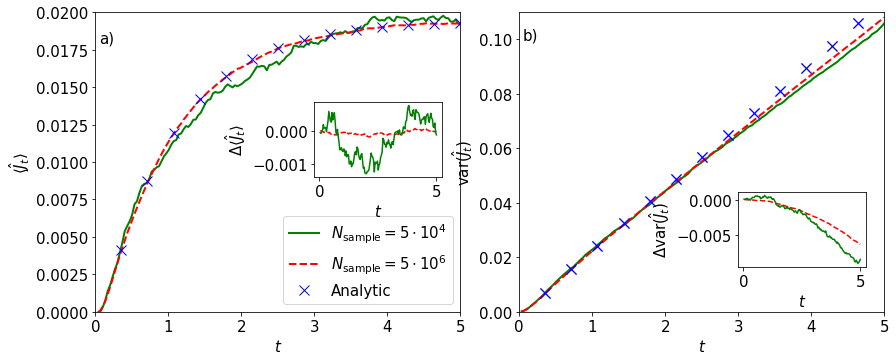

In [36]:
mpl.rcParams.update({'font.size': 15})
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.tight_layout()


ax[0].plot(time[1:], mean2, "g-", label=r"$N_\mathrm{sample}=5\cdot 10^4$", lw=2)
ax[0].plot(time[1:], mean, "r--", label=r"$N_\mathrm{sample}=5\cdot 10^6$", lw=2)
ax[0].plot(t1[1:], J1_mean1, "bx", label="Analytic", ms=10)
# ax[0].fill_between(time[1:], mean-np.sqrt(var), mean+np.sqrt(var),
#     alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')



ax[1].plot(time[1:], var2, "g-", label=r"$N_\mathrm{sample}=5\cdot 10^4$", lw=2)
ax[1].plot(time[1:], var, "r--", label=r"$N_\mathrm{sample}=5\cdot 10^6$", lw=2)
ax[1].plot(t1[1:], J_cov1, "bx", label="Analytic", ms=10)
ax[1].plot(t1[1:], varJ1, "bx", label="Analytic 2", ms=10)


# axins = inset_axes(ax[1], width=1.3, height=0.9, loc=2, bbox_to_anchor=(0.5,1-0.3,.3,.3), bbox_transform=ax.transAxes)
iax1 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax[0], [0.6, 0.45, 0.35, 0.25]) #posx, posy, width, height
iax1.set_axes_locator(ip)

iax1.set_ylabel(r"$\Delta\langle\hat{J}_t\rangle$")
iax1.set_xlabel(r"$t$")

iax1.plot(time[1:], mean - J1_mean2, "r--")
iax1.plot(time[1:], mean2 - J1_mean2, "g-")


# axins = inset_axes(ax[1], width=1.3, height=0.9, loc=2, bbox_to_anchor=(0.5,1-0.3,.3,.3), bbox_transform=ax.transAxes)
iax = plt.axes([0, 0, 0, 0])
ip = InsetPosition(ax[1], [0.6, 0.15, 0.35, 0.25]) #posx, posy, width, height
iax.set_axes_locator(ip)

iax.set_ylabel(r"$\Delta \mathrm{var}(\hat{J}_t)$")
iax.set_xlabel(r"$t$")

iax.plot(time[1:], var - J_cov2, "r--")
iax.plot(time[1:], var2 - J_cov2, "g-")

# ax[0].set_yscale("log")
# ax[1].set_yscale("log")

ax[0].axis([0, 5, 0, 0.02])
ax[1].axis([0, 5, 0, 0.11])

ax[0].annotate('a)', xy=(0.05, 0.018), xytext=(0.05, 0.018))
ax[1].annotate('b)', xy=(0.05, 0.1), xytext=(0.05, 0.1))

ax[0].set_ylabel(r"$\langle \hat{J}_t\rangle$")
ax[0].set_xlabel(r"$t$")
ax[1].set_ylabel(r"var$(\hat{J}_t)$")
ax[1].set_xlabel(r"$t$")
ax[0].legend(loc="lower right")
# ax[1].legend(loc="lower right")


plt.savefig("figures/Calmodulin_example_current.pdf", dpi=500, bbox_inches="tight")

In [34]:
print(J_cov1)
print(varJ1)
print(J1_mean1, J2_mean1)
print(mJ1)

[0.00688748 0.01571724 0.02420402 0.03248049 0.04063945 0.04874138
 0.056826   0.06491953 0.0730393  0.08119669 0.08939907 0.09765116
 0.10595582 0.11431469]
[0.00688748 0.01571724 0.02420402 0.03248049 0.04063945 0.04874138
 0.056826   0.06491953 0.0730393  0.08119669 0.08939907 0.09765116
 0.10595582 0.11431469]
[0.00413304 0.00872307 0.01194099 0.01419148 0.01576543 0.01686628
 0.01763629 0.01817496 0.01855186 0.01881563 0.0190003  0.01912965
 0.01922033 0.01928396] [0.00413304 0.00872307 0.01194099 0.01419148 0.01576543 0.01686628
 0.01763629 0.01817496 0.01855186 0.01881563 0.0190003  0.01912965
 0.01922033 0.01928396]
[0.00413304 0.00872307 0.01194099 0.01419148 0.01576543 0.01686628
 0.01763629 0.01817496 0.01855186 0.01881563 0.0190003  0.01912965
 0.01922033 0.01928396]


In [11]:

states = np.arange(0, 6)

in_state = []

size = 50000

A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])
d_matrix = np.array([[0, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])
d2_matrix = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, -1, 0]])



for i in range(size):
    in_state.append(initial_state(peq, states))



J1_mean, J2_mean, J_cov = current_covariance_sample(size, time, in_state, L, d_matrix, d2_matrix)

############# SAMPLE DONE ################


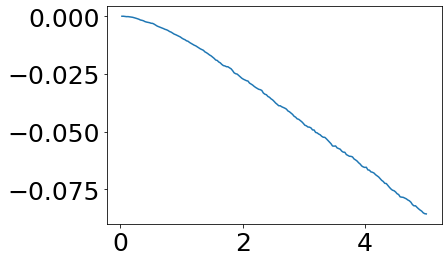

In [12]:
plt.plot(time[1:], J_cov)

In [29]:
V = np.array([1, 1, 0, 0, 0, 0])

size = 50000

for i in range(size):
    in_state.append(initial_state(peq, states))
Jmean, Jvar, rho_mean, rho_var, Jrho_cov = current_density_sample(size, np.linspace(0, 5, 200), in_state, L, d_matrix, V)

/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'init_state' of function 'current_density_sample'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-28-328abf404af0>", line 122:
@njit(parallel=True)
def current_density_sample(n_sample:int, time: np.ndarray, init_state:int, L:np.ndarray, d: np.ndarray, V: np.ndarray):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'init__state' of function '__numba_parfor_gufunc_0x7fc35863fd50'.

For more information

############# SAMPLE DONE ################


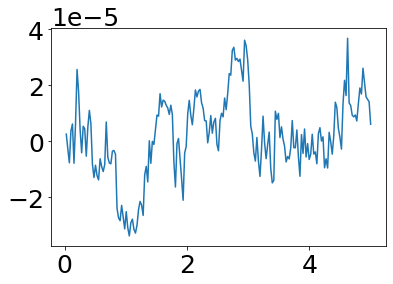

In [30]:
plt.plot(time[1:], Jrho_cov)

[ 1.76652515e+00  1.34219031e+00  1.11672066e+00  9.70795338e-01
  8.62255032e-01  7.68999471e-01  6.87854722e-01  6.16621820e-01
  5.57769021e-01  5.04676689e-01  4.54676747e-01  4.07503144e-01
  3.65843141e-01  3.30783022e-01  3.00074116e-01  2.73520654e-01
  2.46173585e-01  2.22945321e-01  2.02061576e-01  1.81816025e-01
  1.63889989e-01  1.49642150e-01  1.35318594e-01  1.22205899e-01
  1.10365432e-01  1.00130166e-01  9.14149901e-02  8.43088232e-02
  7.75164583e-02  7.09569399e-02  6.55109641e-02  6.00658050e-02
  5.45526958e-02  5.00755992e-02  4.55195094e-02  4.18274599e-02
  3.78291969e-02  3.47172722e-02  3.20001586e-02  2.87198526e-02
  2.62339372e-02  2.34329796e-02  2.15886198e-02  1.95781231e-02
  1.84560220e-02  1.74144358e-02  1.55698799e-02  1.39637845e-02
  1.29981335e-02  1.18722452e-02  1.09889745e-02  1.01088775e-02
  9.07015752e-03  8.11055090e-03  7.39310942e-03  6.51696494e-03
  5.72359019e-03  5.48642338e-03  4.76924845e-03  4.45843777e-03
  4.05909721e-03  3.02038

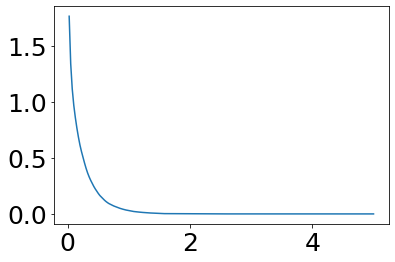

In [34]:

# plt.plot(time[1:], rho_mean)
plt.plot(time[1:],rho_mean - np.ones_like(time[1:]) * (peq[0] + peq[1]))


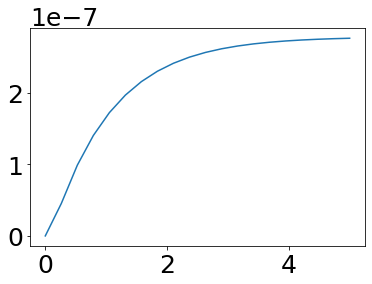

In [18]:
t = np.linspace(0, 5, 20)

def test_correlation(t, k, l):
    res = 0

    prop = la.expm(L * t)

    return (peq[k] + peq[l]) * (prop[k, l] * L[l, k] - prop[l, k] * L[k, l])

res = []

for i in t:
    res.append(test_correlation(i, 4, 5))

plt.plot(t, res)


In [14]:
# d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 1], [0, -1, 0, 0, -1, 0]])
d_matrix = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 1, 0, 0, 1, 0]])

frame.printMatrix(d_matrix)


0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   1.00   0.00   0.00   1.00   0.00   

